In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import torch.nn as nn
from glob import glob
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import product
from torch.utils.data import TensorDataset, DataLoader
from astra.torch.models import ResNetClassifier
from astra.torch.utils import train_fn

import torchvision.models as models
from astra.torch.metrics import accuracy_score, f1_score, precision_score, recall_score



In [2]:
# Load the saved tensors
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")

# Access the tensors
index = loaded_data['index']
images = loaded_data['images']
labels = loaded_data['labels']
images = images / 255
    # mean normalize
images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)

In [3]:
#print shape of tensors
print(images.shape)
print(labels.shape)
#print the labels
print(labels)
#count the number of unique labels
# count the number of 1s and 0s
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))


torch.Size([25500, 3, 224, 224])
torch.Size([25500])
tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8)
{0: 23803, 1: 1697}


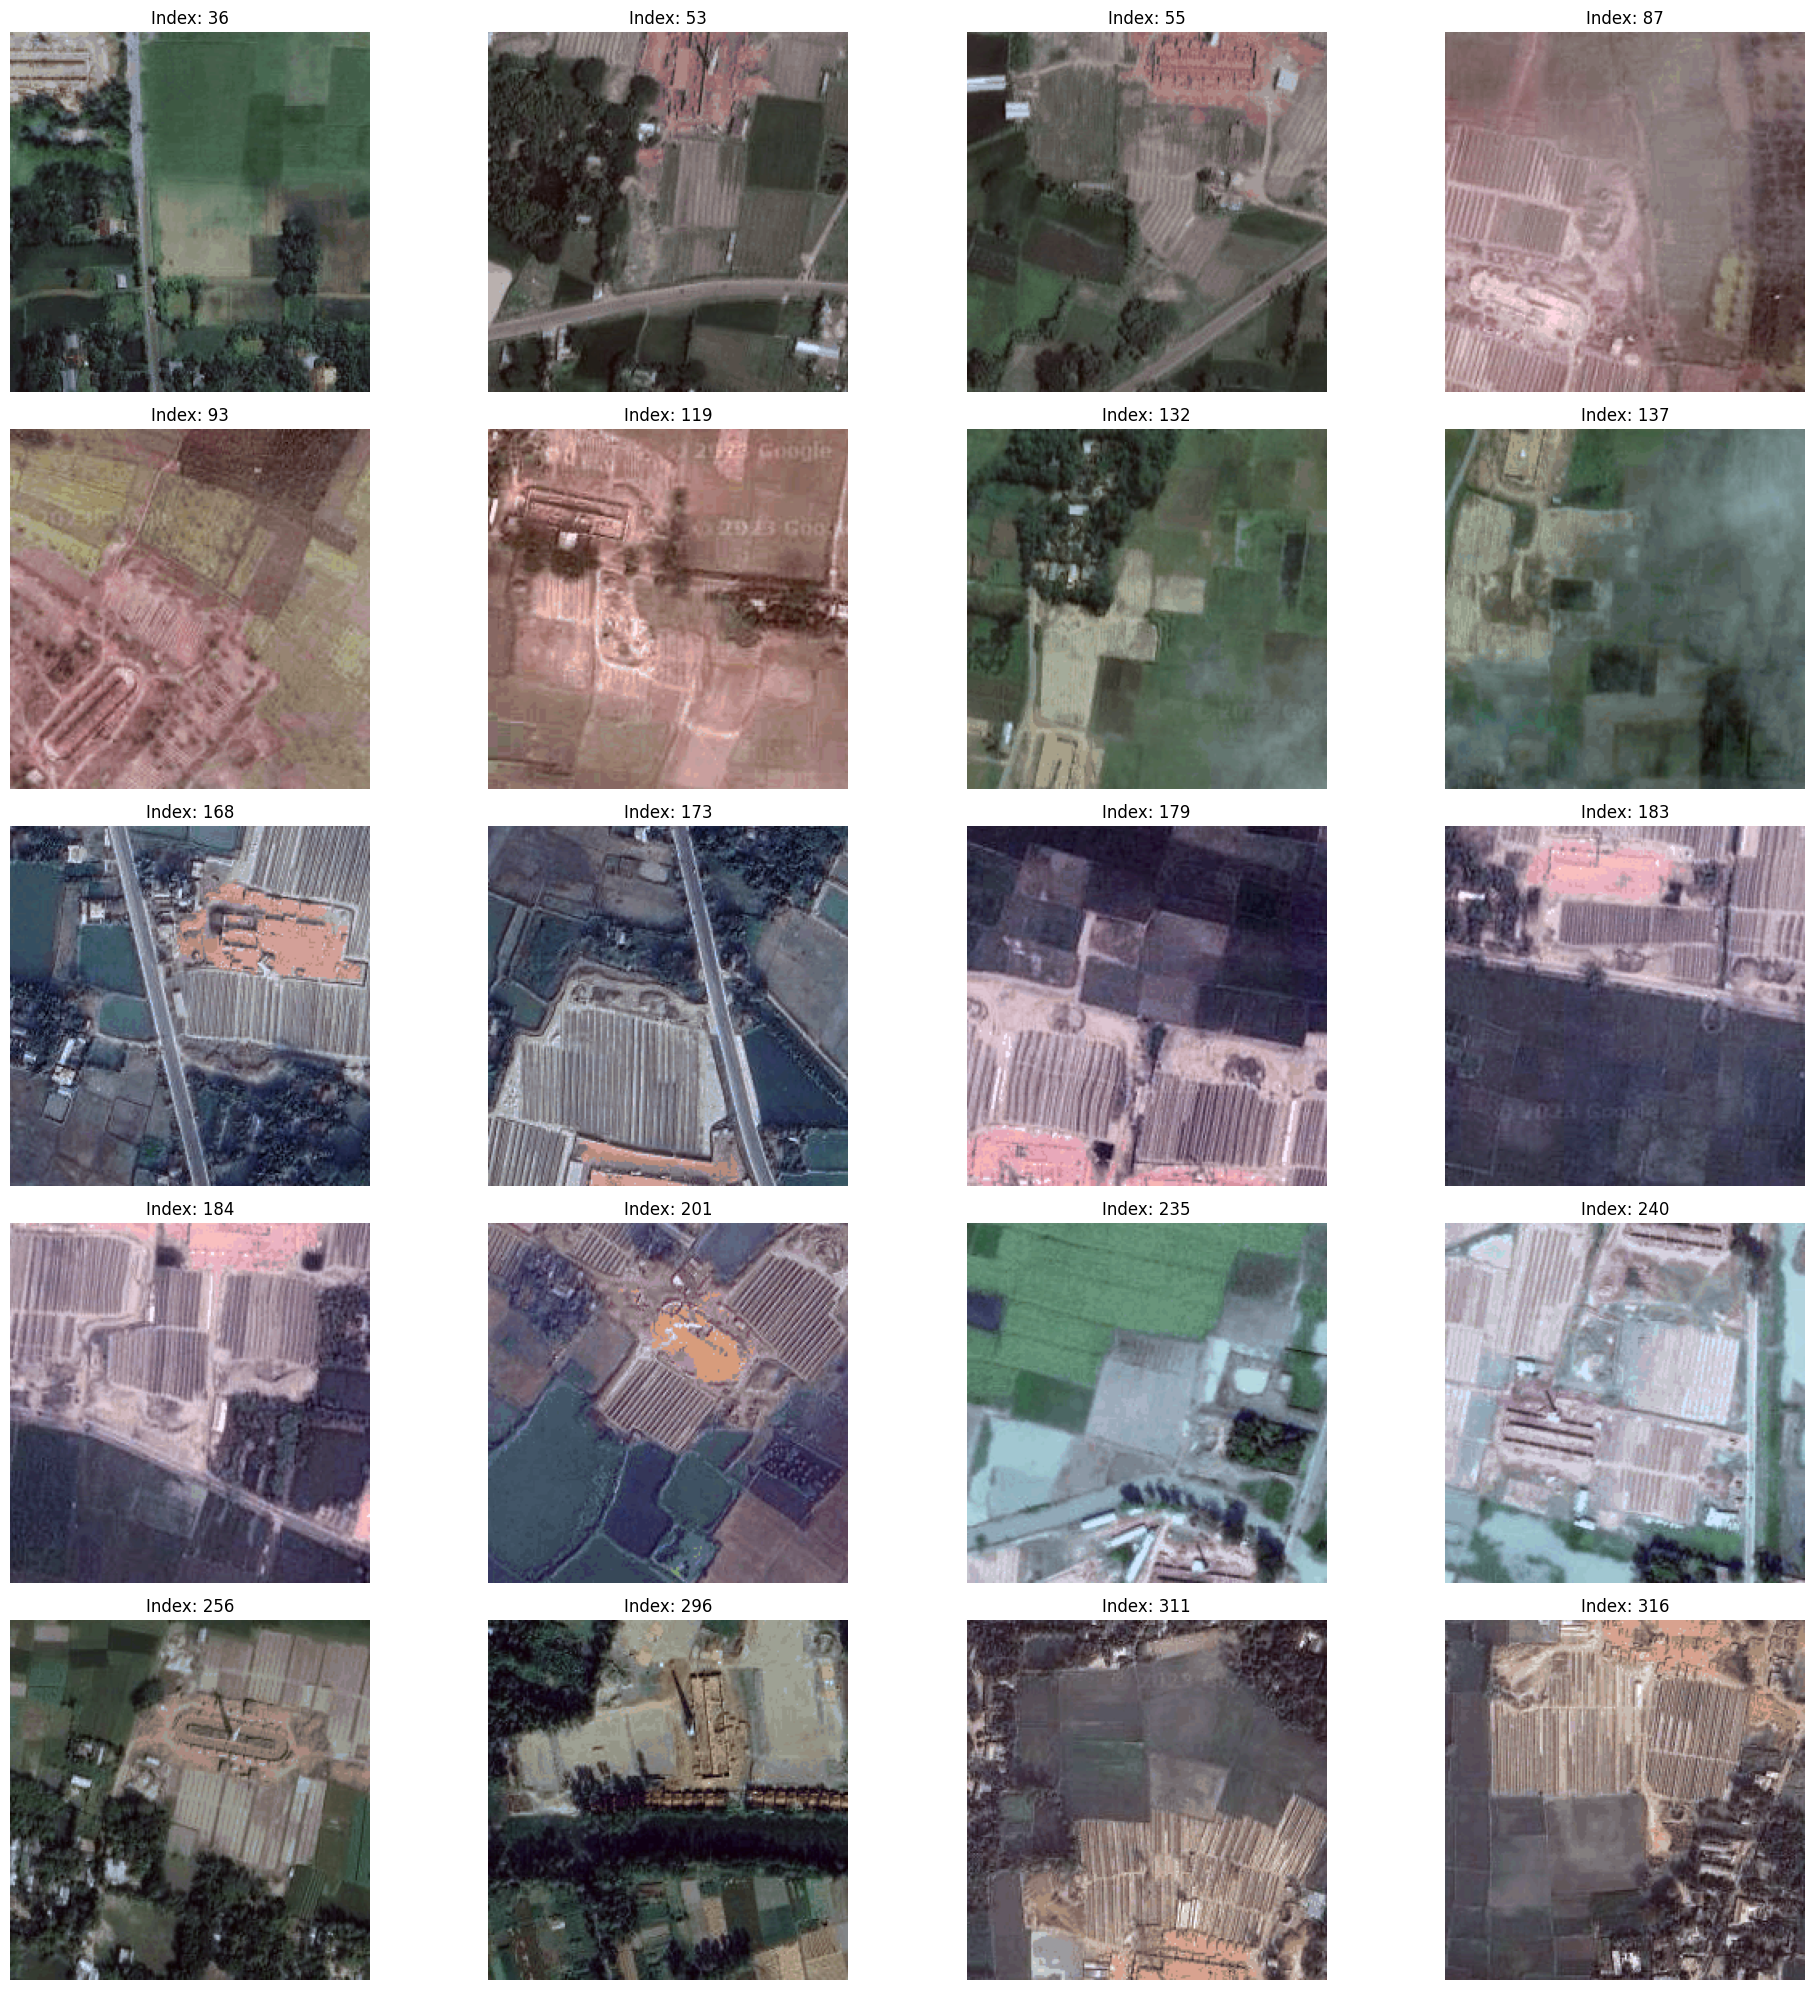

In [4]:
# visualize the images of positive classes
import matplotlib.pyplot as plt
import numpy as np

def plot_images_with_label(images, labels, label_value=1, max_images=20, figsize=(20, 20)):
    # Find indices where the label matches the specified value
    indices = np.where(labels == label_value)[0]

    # Limit the number of images to 20
    indices = indices[:max_images]

    # Determine the number of rows and columns for subplots
    num_images = len(indices)
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    # Create a single figure with subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Iterate over indices and plot images
    for i, ax in zip(indices, axs.flatten()):
        image_np_original = images[i].numpy()
        image_np_normalized = (image_np_original - image_np_original.min()) / (image_np_original.max() - image_np_original.min())
        ax.imshow(np.transpose(image_np_normalized, (1, 2, 0)))
        ax.set_title(f'Index: {i}')
        ax.axis('off')
    plt.tight_layout()

# Example usage
plot_images_with_label(images, labels, label_value=1, max_images=20, figsize=(20, 20))


In [5]:
train_dataset = TensorDataset(images[:17000], labels[:17000])

test_dataset = TensorDataset(images[17000:], labels[17000:])

print(len(train_dataset))
print(len(test_dataset))

17000
8500


In [6]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
train_model = ResNetClassifier(
    models.resnet18, None, n_classes=2, activation=nn.GELU(), dropout=0.1
).to(device)

iter_losses, epoch_losses = train_fn(
    train_model,
    nn.CrossEntropyLoss(),
    dataloader=train_loader,
    lr=3e-4,
    epochs=100,
    verbose=True,
    wandb_log=False,
)

Loss: 0.00001963: 100%|██████████| 100/100 [24:40<00:00, 14.81s/it]


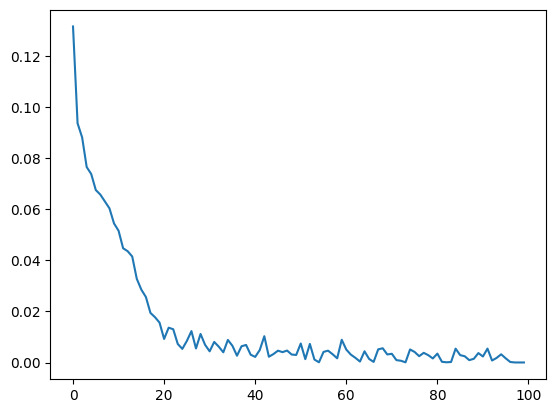

In [9]:
plt.plot(epoch_losses)

In [10]:
with torch.no_grad():
    pred_classes =train_model.predict_class(
        dataloader=test_loader, batch_size=batch_size, verbose=True
    ).to(device)

test_labels = labels[17000:].to(device)
print(test_labels.shape, pred_classes.shape)
print("Accuracy: ", accuracy_score(test_labels, pred_classes))
print("Precision: ", precision_score(test_labels, pred_classes))
print("Recall: ", recall_score(test_labels, pred_classes))
print("F1: ", f1_score(test_labels, pred_classes))

100%|██████████| 133/133 [00:06<00:00, 19.42it/s]

torch.Size([8500]) torch.Size([8500])
Accuracy:  tensor(0.9728, device='cuda:0')
Precision:  tensor(0.7124, device='cuda:0')
Recall:  tensor(0.8880, device='cuda:0')
F1:  tensor(0.7906, device='cuda:0')
